In [26]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import numpy as np
from scipy.stats import norm
from scipy.optimize import root_scalar
from scipy.stats import gaussian_kde


from recsysconfident.data_handling.post_processing import Processing


def solve_normal_pdf(mu: float, std: float, estimation: float) -> float | None:

    def equation(x):
        return x - norm.pdf(x, loc=mu, scale=std) # x - normal_pdf(x, mu, sigma) = 0

    result = estimation
    try:
        solution = root_scalar(equation, bracket=[-10*std + estimation, 10*std + estimation], method='brentq')
        if solution.converged:
            result = solution.root
    except Exception as e:
        pass

    return result

def double_line(x, mean=0):
    return np.abs(x - mean)

def open_error_conf_dfs(root_dir: str, split_name: str="test", k_instance: int=4) -> dict:

    test_conf_dfs = dict()

    for sub_folder in os.listdir(root_dir):
        
        for csv_uri in glob.glob(f"{root_dir}/{sub_folder}/**.csv"):

            csv_name = f"{split_name}_error_conf-{k_instance}.csv"
            if csv_name in csv_uri:

                setup = json.loads(open(f"{root_dir}/{sub_folder}/setup-{k_instance}.json").read())
                metrics = json.loads(open(f"{root_dir}/{sub_folder}/metrics-{k_instance}.json").read())

                error_conf_df = pd.read_csv(csv_uri).dropna()
                postprocessing = Processing(setup['rate_range'])
                error_conf_df = postprocessing.parse_clip_shift(error_conf_df, setup.get("abs_shift_conf", False))
                
                error_conf_df.sort_values(by='conf_pred', inplace=True)
                error_conf_df.loc[:, "error"] = np.abs(error_conf_df['rating'] - error_conf_df['r_pred'])
                
                if not setup['database_name'] in test_conf_dfs.keys():
                    test_conf_dfs[setup['database_name']] = {}
                
                model_name = setup['model_name'].replace("mf-clustering", "mf-cluster").replace("mf-non-reg", "mf-not-reg")
                test_conf_dfs[setup['database_name']][model_name] = {
                            "df": error_conf_df,
                            "ranking": metrics
                        }
                
    return test_conf_dfs

def thresholds(data: dict):
    
    result_df = data['df']
    if not data['ranking'].get("eval_conf_threshold@10", None):
        C_T10 = solve_normal_pdf(result_df['conf_pred'].mean(),
                                           result_df['conf_pred'].std(),
                                           result_df['conf_pred'].quantile(0.98))
        C_T3 = C_T10
    else:
        C_T10 = data['ranking'].get("eval_conf_threshold@10", result_df['conf_pred'].quantile(0.9))
        C_T3 = data['ranking'].get("eval_conf_threshold@3", result_df['conf_pred'].quantile(0.9))
    
    return C_T10, C_T3

def plot_tensors(x, y, C_T10, C_T3, xlabel="x", ylabel="y", ax=None):
    ax.scatter(x, y, color='green')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.axvline(x=C_T10, color='red', linewidth=3)
    #ax.axvline(x=C_T3, color='orange', linewidth=3)
    #ax.set_xlim(0, 1)  # Fix x-axis range to [0, 1]
    ax.grid(True)

def plot_error_conf(grouped_data: dict, split_type: str, models_names: list[str]):
    # Group data by prefix

    plt.rcParams.update({'font.size': 30})

    # Plot each group of datasets in a single row of subplots
    for dataset_name, dataset_info in grouped_data.items():
        n = len(models_names)
        fig, axes = plt.subplots(1, n, figsize=(8 * n, 6))  # Adjust size for multiple plots
        if n == 1:
            axes = [axes]  # Ensure axes is iterable if only one plot
        
        print(dataset_name)
        
        for ax, model_name in zip(axes, models_names):
            data = dataset_info[model_name.lower()]
            result_df = data['df']

            C_T10, C_T3 = thresholds(data)
                
            plot_tensors(
                result_df['conf_pred'].values,
                result_df['bpr_error'].values,
                C_T10,
                C_T3,
                "Confidence",
                "Error",
                ax=ax,
            )
            ax.set_title(model_name.replace(f"{dataset_name}-", ""))

        plt.tight_layout()
        plt.savefig(f"./plots/error-conf-{dataset_name}-{split_type}.png")
        plt.show()

def plot_dist(confidence_arr, axes, i):

    mean, std = np.mean(confidence_arr), np.std(confidence_arr)
    x_values = np.linspace(min(confidence_arr), max(confidence_arr), 1000)
    pdf_values = norm.pdf(x_values, mean, std)

    # Plot histogram and KDE
    axes[i].plot(x_values, pdf_values, color='orange', linewidth=2)

def plot_distributions_horizontally(datasets: list[dict], fig_name: str, models: list[str]):
    """
    Plot the 'conf_pred' distributions horizontally for each dataset, allowing individual y-axis scaling.

    Parameters:
        datasets (list): A list of dictionaries with keys "df" (dataframe) and "name" (dataset name).
    """
    num_datasets = len(models)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 6), dpi=300)  # Removed sharey=True

    # Ensure `axes` is iterable even if there's only one subplot
    if num_datasets == 1:
        axes = [axes]

    for i, name in enumerate(models):
        df = datasets[name.lower()]["df"]
        confidence_arr = df["conf_pred"].values

        sns.histplot(confidence_arr, kde=True, color='blue', bins=30, stat="density", ax=axes[i])

        # Compute the Gaussian PDF
        #plot_dist(confidence_arr, axes, i)

        # Plot the confidence line
        #sorted_array = np.sort(confidence_arr)
        #axes[i].plot(sorted_array, sorted_array, color='orange', linewidth=2, )
        
        #C_T10, C_T3 = thresholds(data)
        #axes[i].axvline(x=C_T10, color='red', linewidth=3)
        #axes[i].axvline(x=C_T3, color='orange', linewidth=3)
        
        # Add labels, legend, and grid
        axes[i].set_title(name)
        axes[i].set_xlabel("Confidence")
        axes[i].set_ylabel("Density")
        #axes[i].legend()
        axes[i].grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig(f"./plots/{fig_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

def plot_boxplots_horizontally(datasets: list[dict], plot_name: str, models: list[str]):

    num_datasets = len(models)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 4), dpi=300)

    if num_datasets == 1:
        axes = [axes]

    for i, name in enumerate(models):
        df = datasets[name.lower()]["df"]
        confidence_arr = df["conf_pred"].values

        sns.boxplot(x=confidence_arr, ax=axes[i], color='lightblue')
        axes[i].set_title(name)
        axes[i].set_xlabel("Confidence")
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig(f"./plots/{plot_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

def plot_conf_error_corr_bar(data, plot_name: str):
    df = pd.DataFrame(data)

    # Ensure each row is treated individually by resetting the index and pivoting by row
    pivot_df = pd.DataFrame([df['conf_error_corr'].values], columns=df['name'].values)
    pivot_df.columns.name = None  # Remove label 'name'

    plt.figure(figsize=(pivot_df.shape[1] * 2.5, 3))

    ax = sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".2f",
        cmap='vlag',
        linewidths=.5,
        linecolor='black',
        annot_kws={"fontsize": 12},
        vmin=-1,  # Set lower bound for color scale
        vmax=0
    )

    # Remove title and color bar label
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(12)

    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.savefig(f"./plots/{plot_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

def obtain_models_corr(test_results_dict: dict, model_names: list[str]):

    models_corr = dict()

    for dataset in test_results_dict.keys():

        models_results = test_results_dict[dataset]

        for model_name in model_names:
            model_result = models_results[model_name.lower()]
            df_model_conf_error_df = model_result['df']
            conf_error_corr = np.corrcoef(df_model_conf_error_df['conf_pred'], df_model_conf_error_df['abs_error'])[0, 1]

            if not dataset in models_corr:
                models_corr[dataset] = []

            models_corr[dataset].append({
                "name": model_name,
                "conf_error_corr": conf_error_corr
            })
    return models_corr



In [27]:
k_instance = 1
group_name = "learn-rank"
model_names = ['learn-rank-cpgatbpr', 'learn-rank-cpmfbpr', 'learn-rank-att-cluster']
test_results_dict = open_error_conf_dfs(f"../runs/{group_name}", k_instance=k_instance)

amazon-beauty


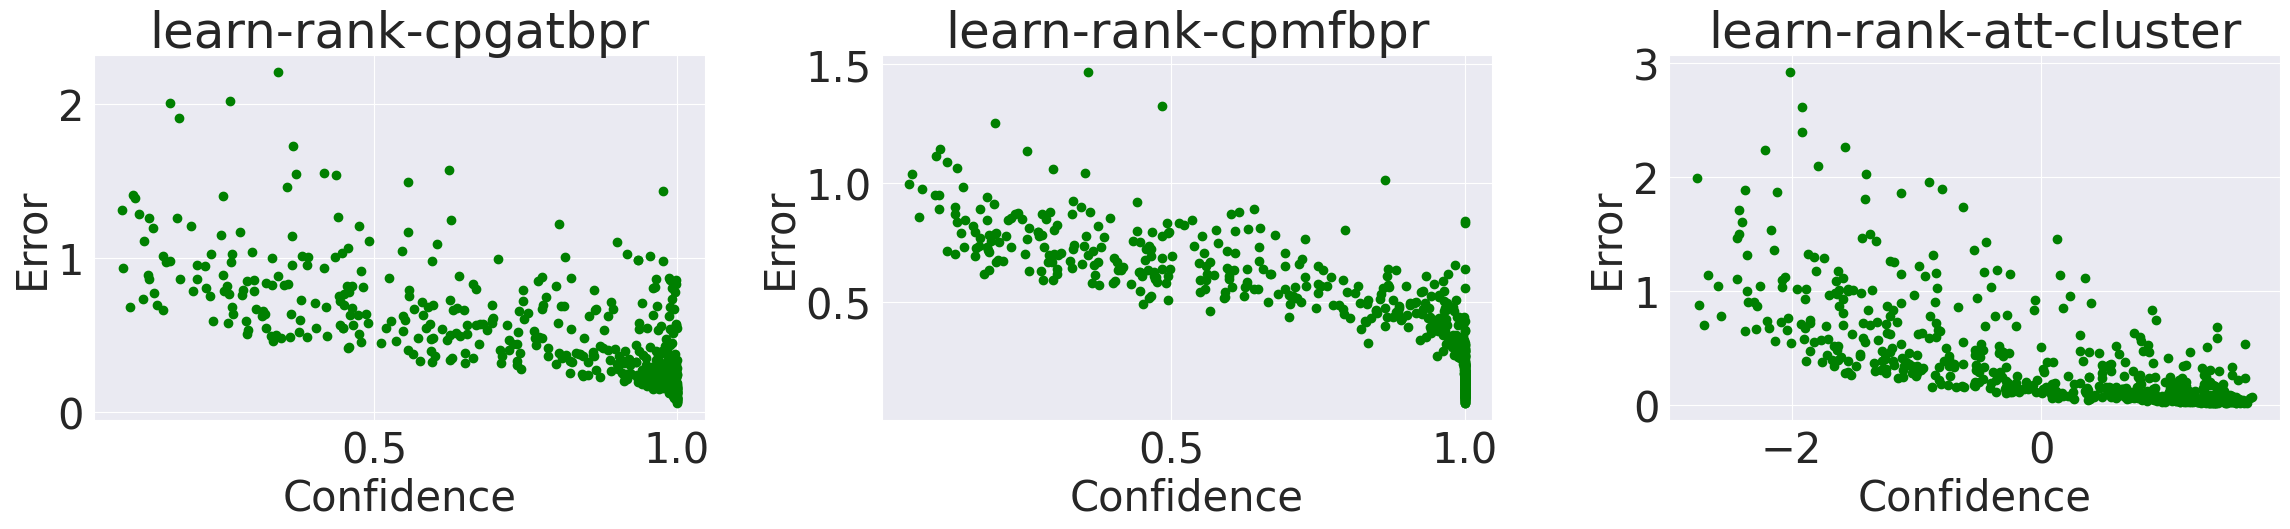

rotten-tomatoes


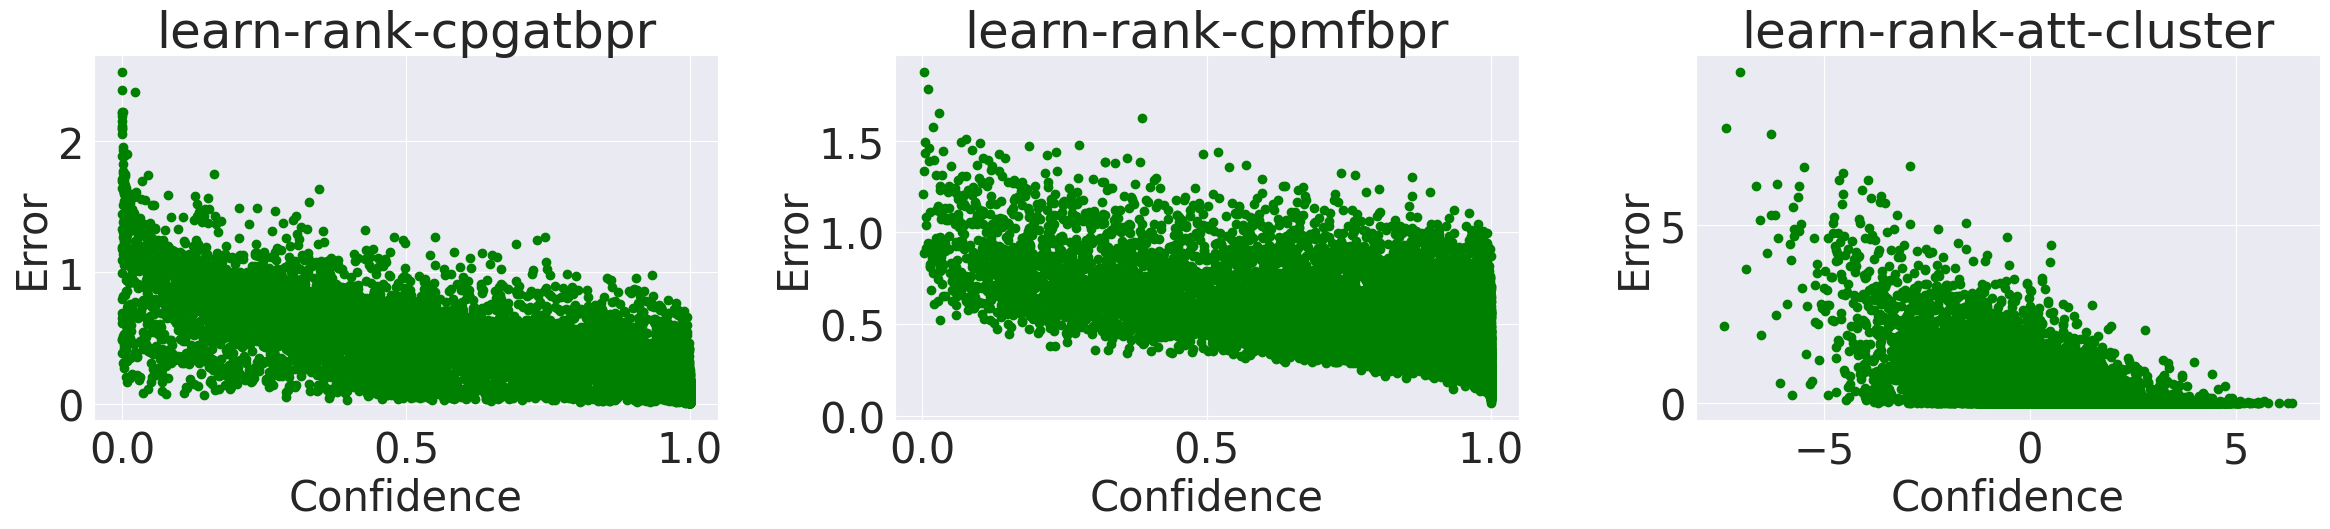

ml-1m


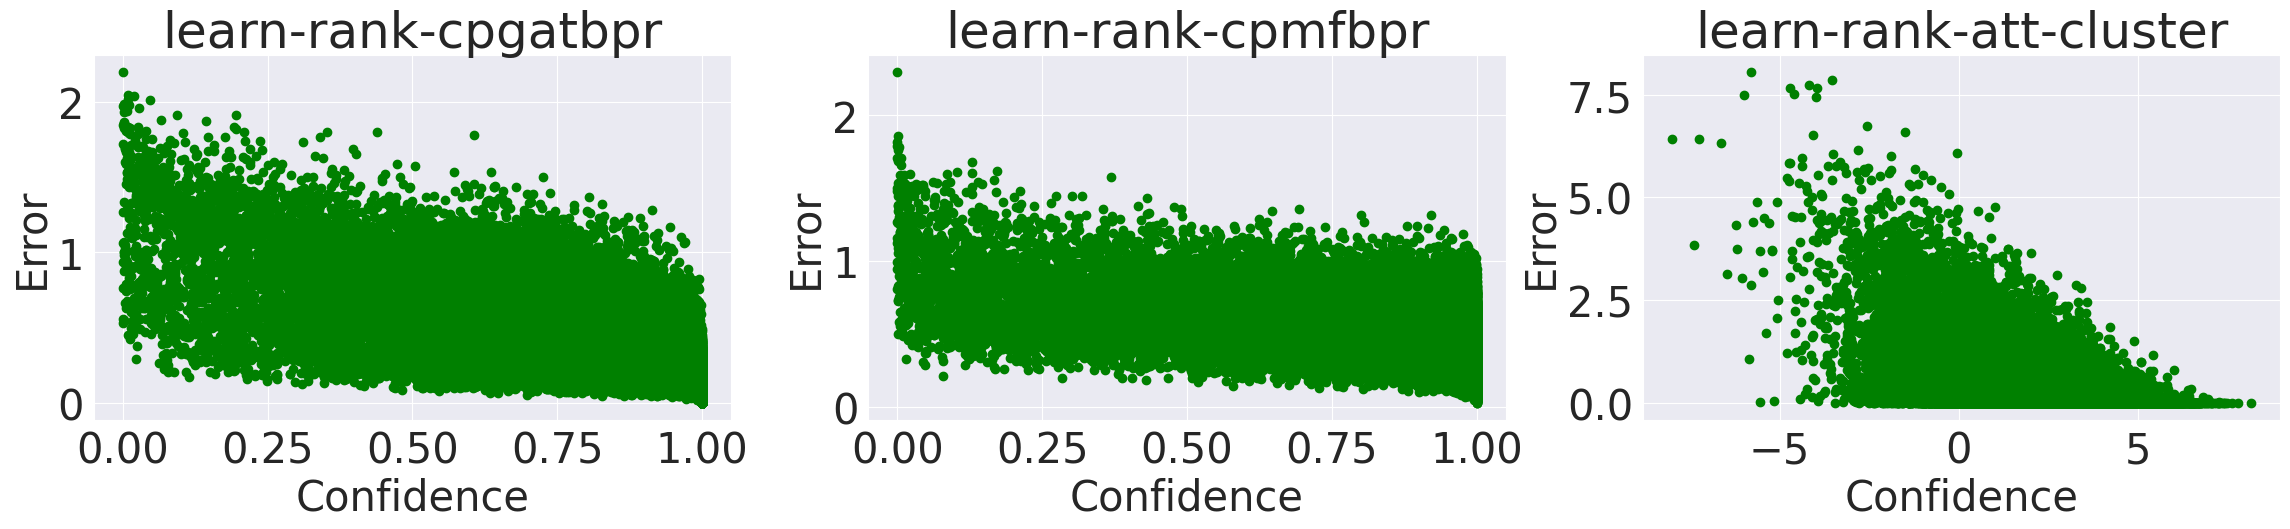

jester-joke


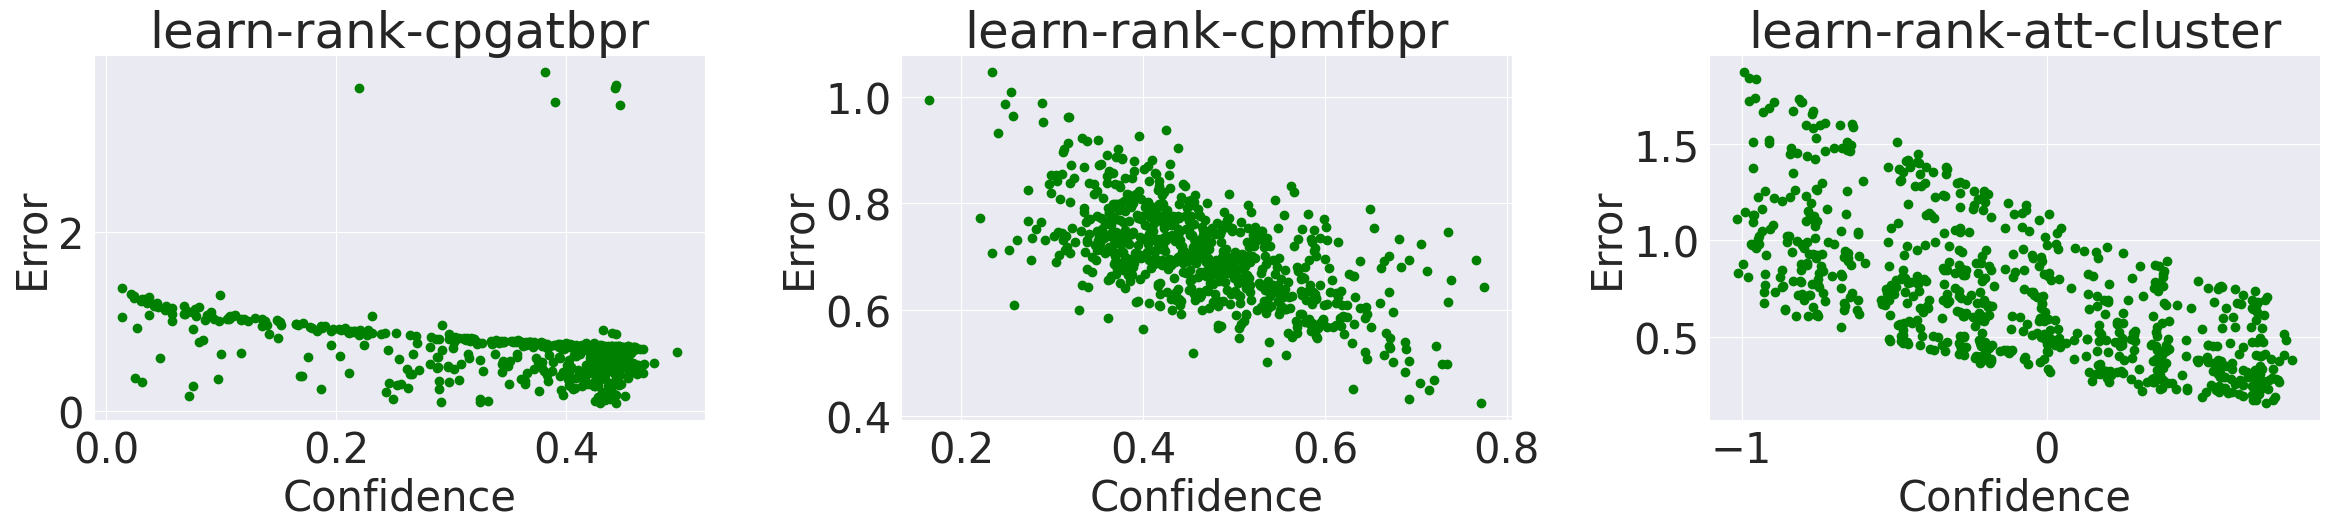

In [28]:
plot_error_conf(test_results_dict, "test", model_names)

amazon-beauty


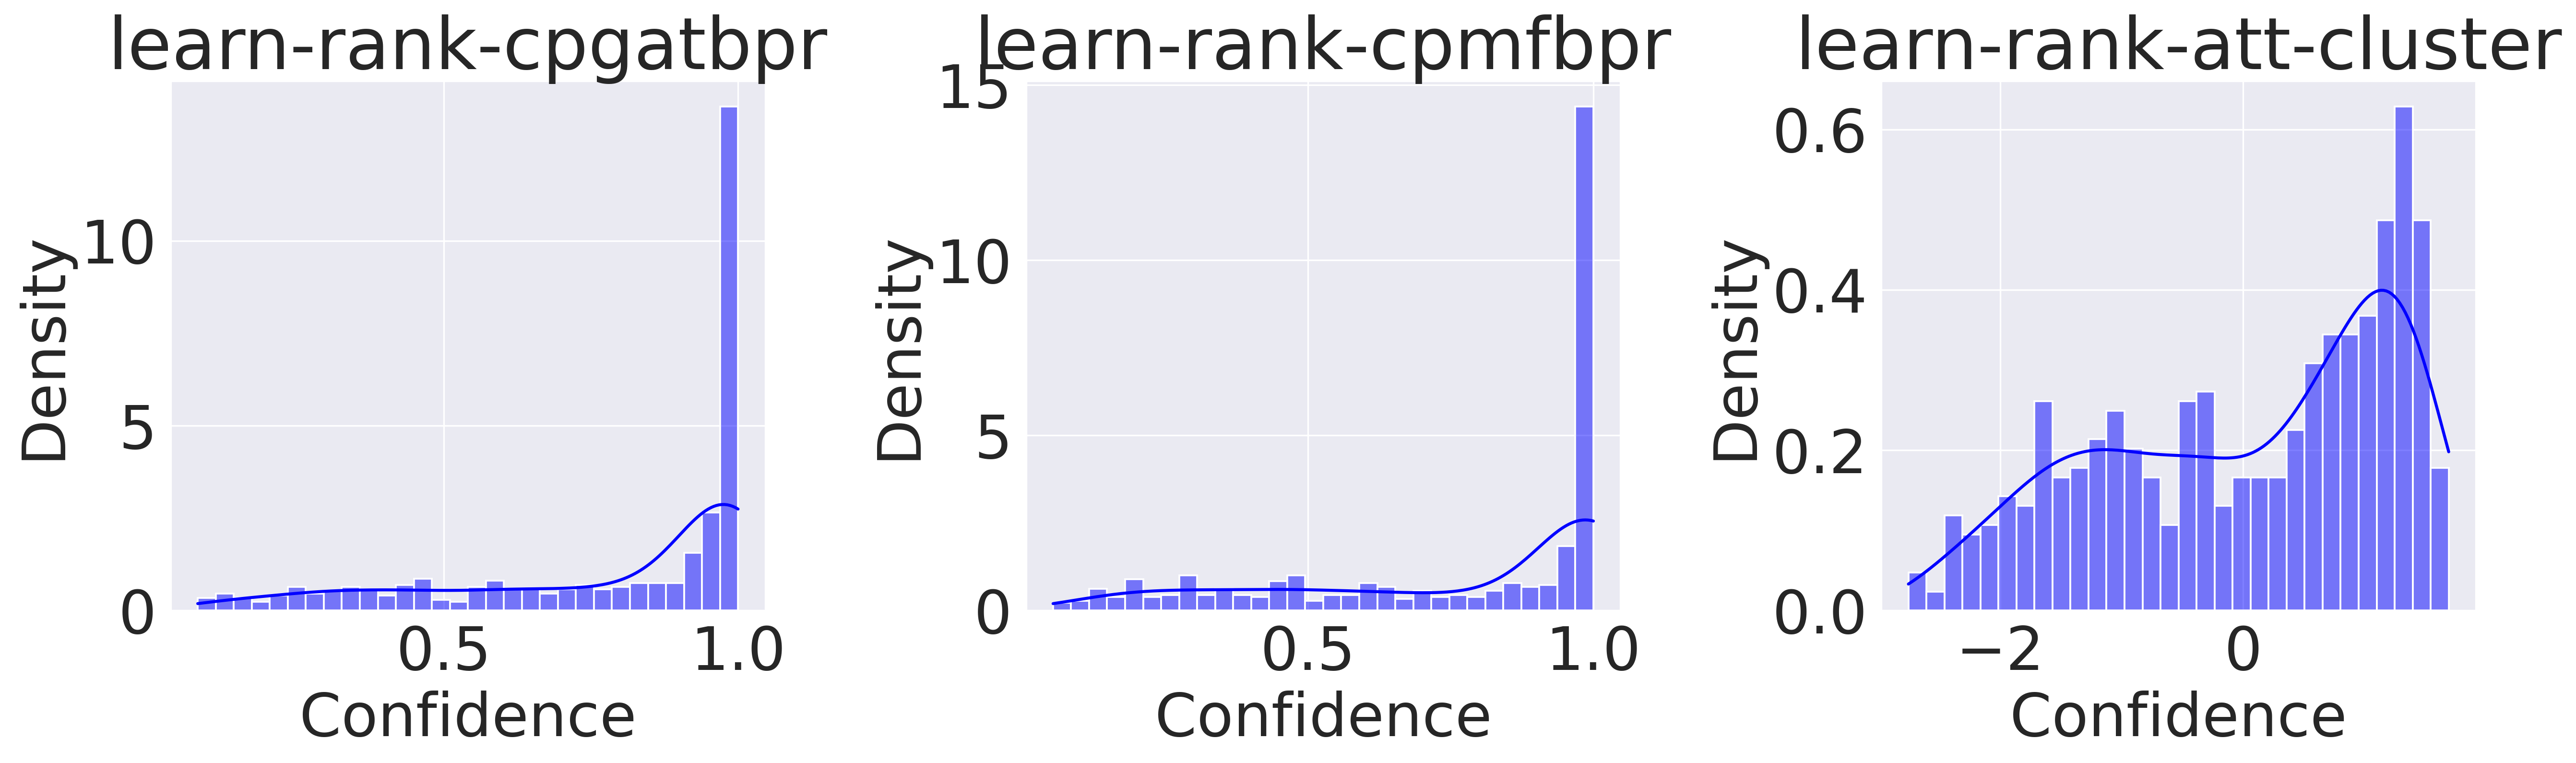

rotten-tomatoes


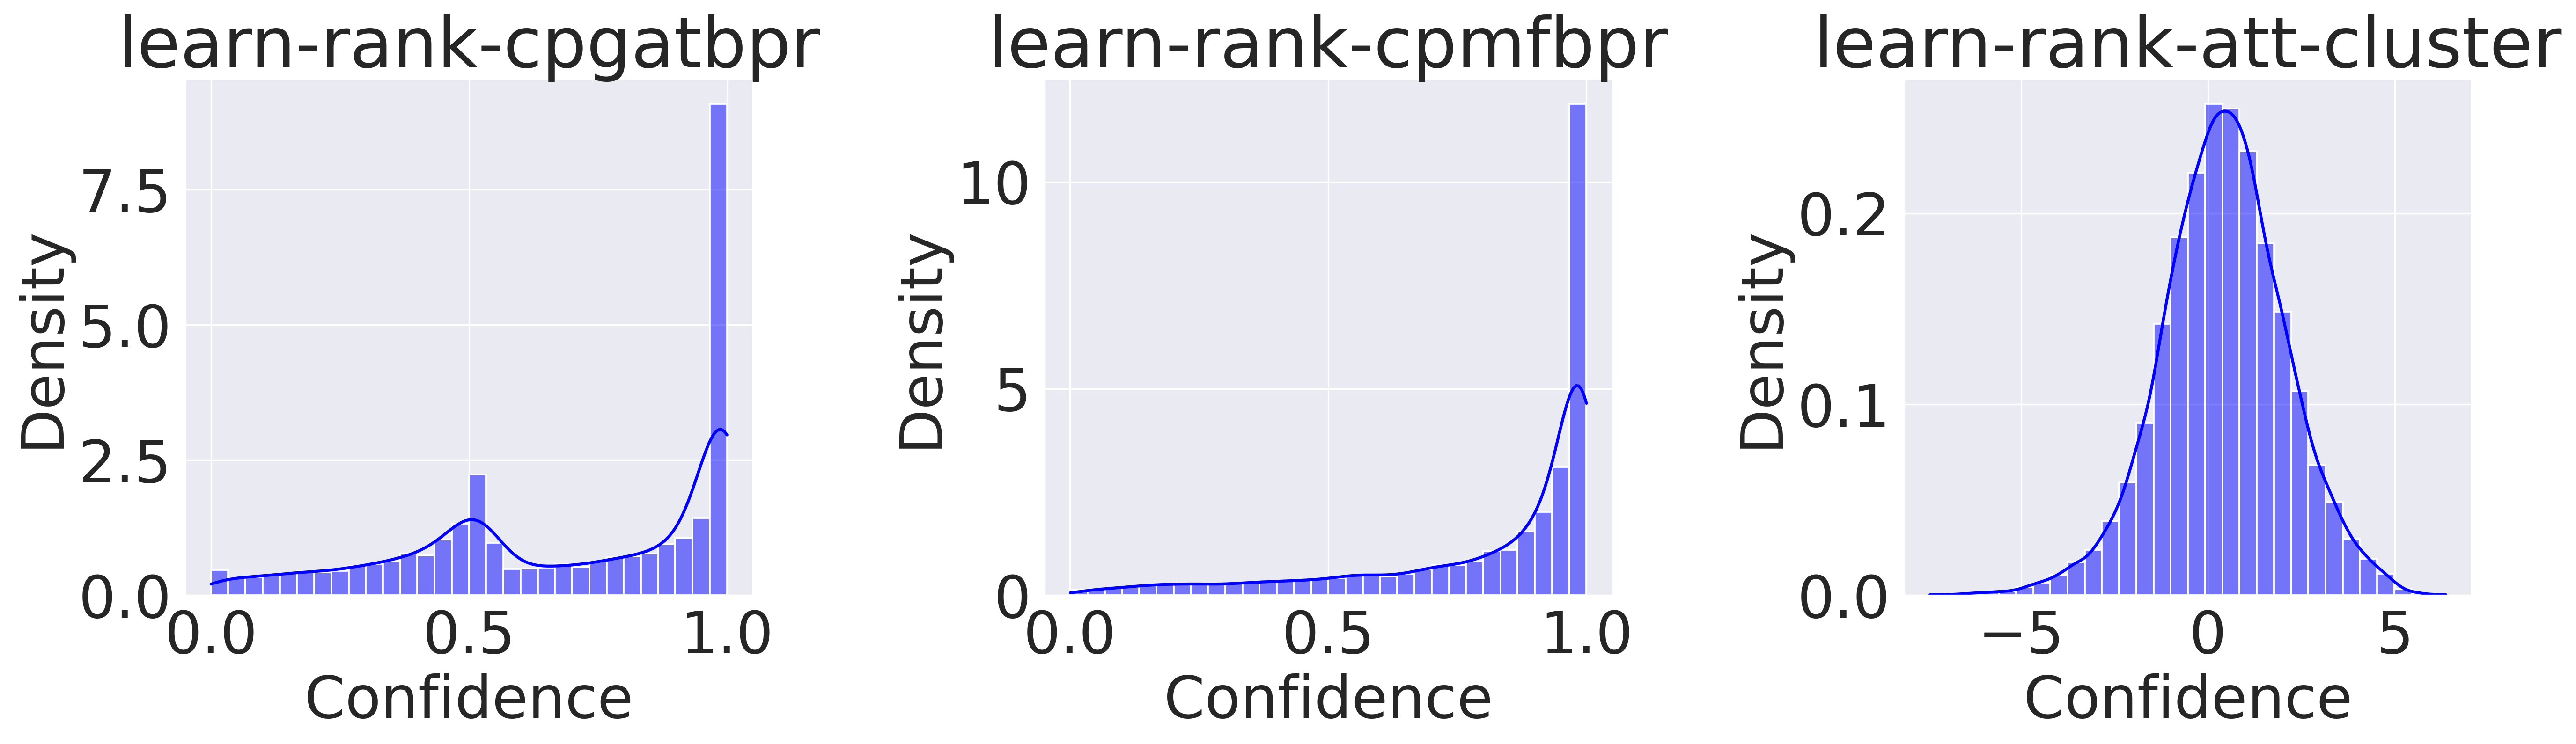

ml-1m


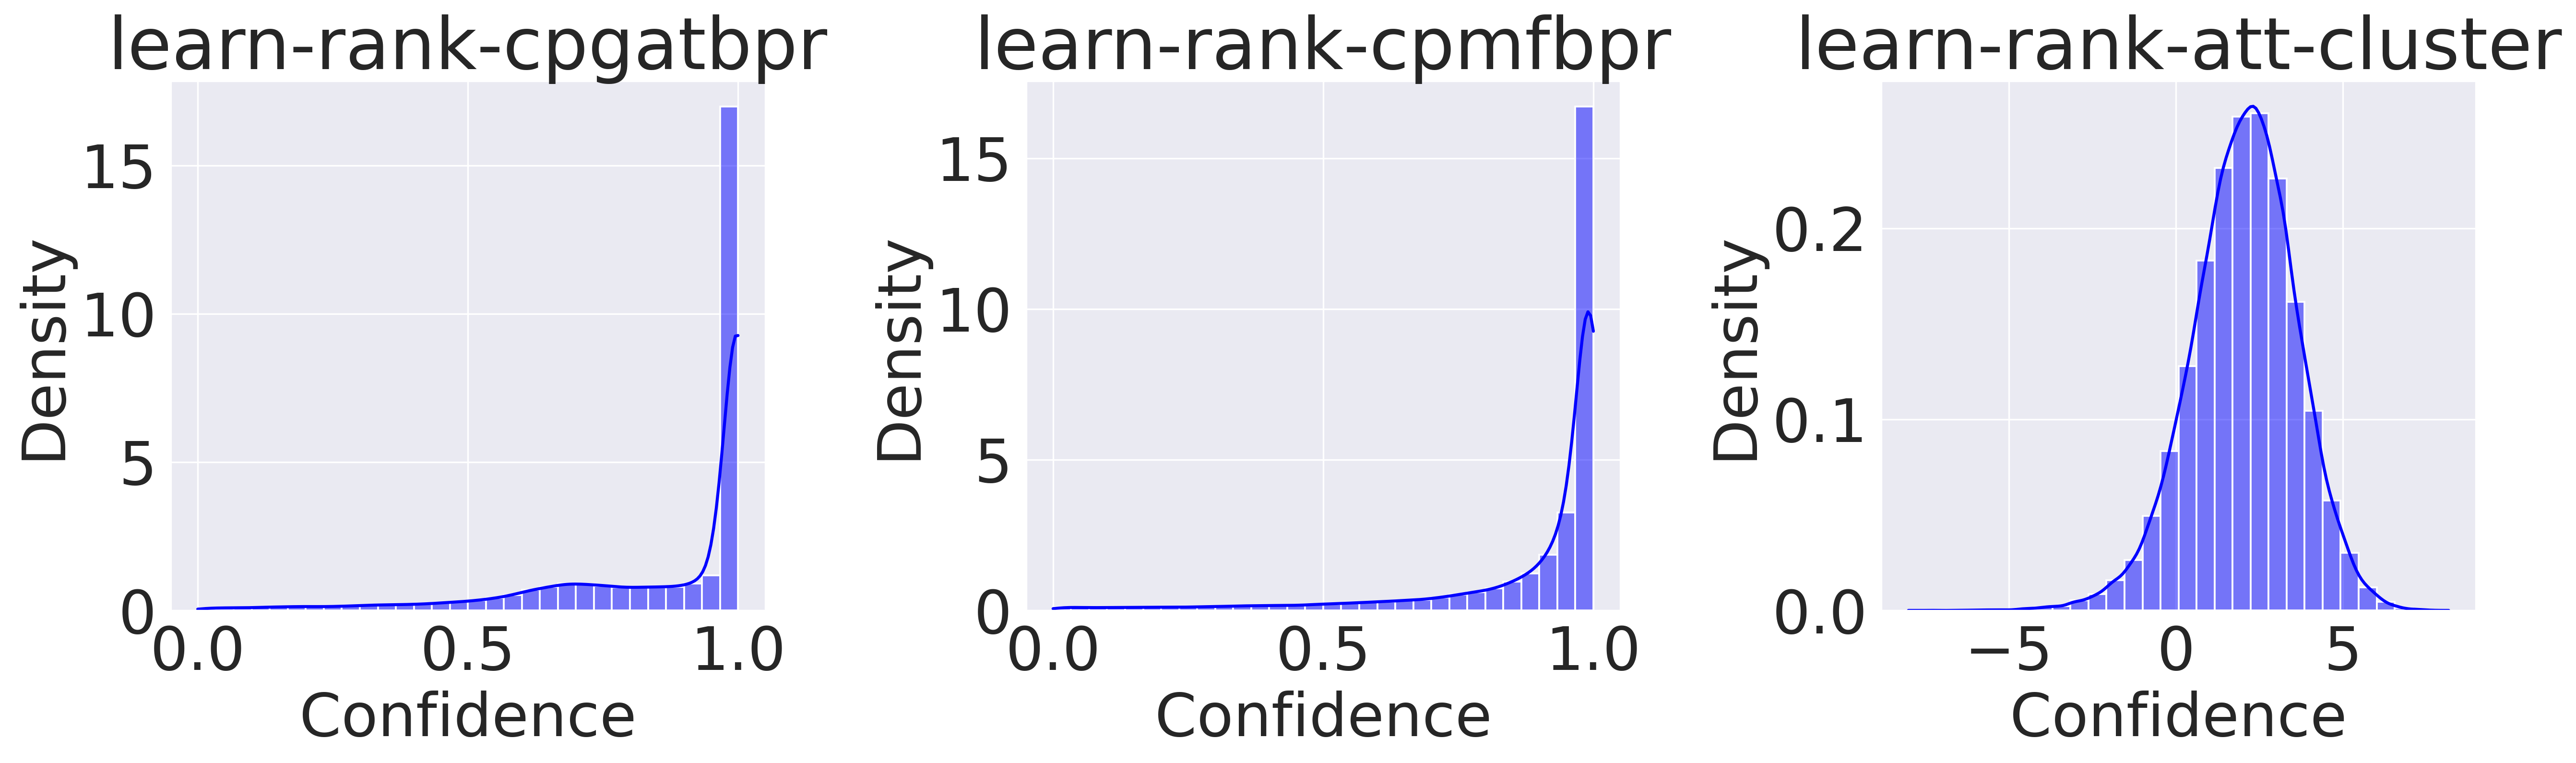

jester-joke


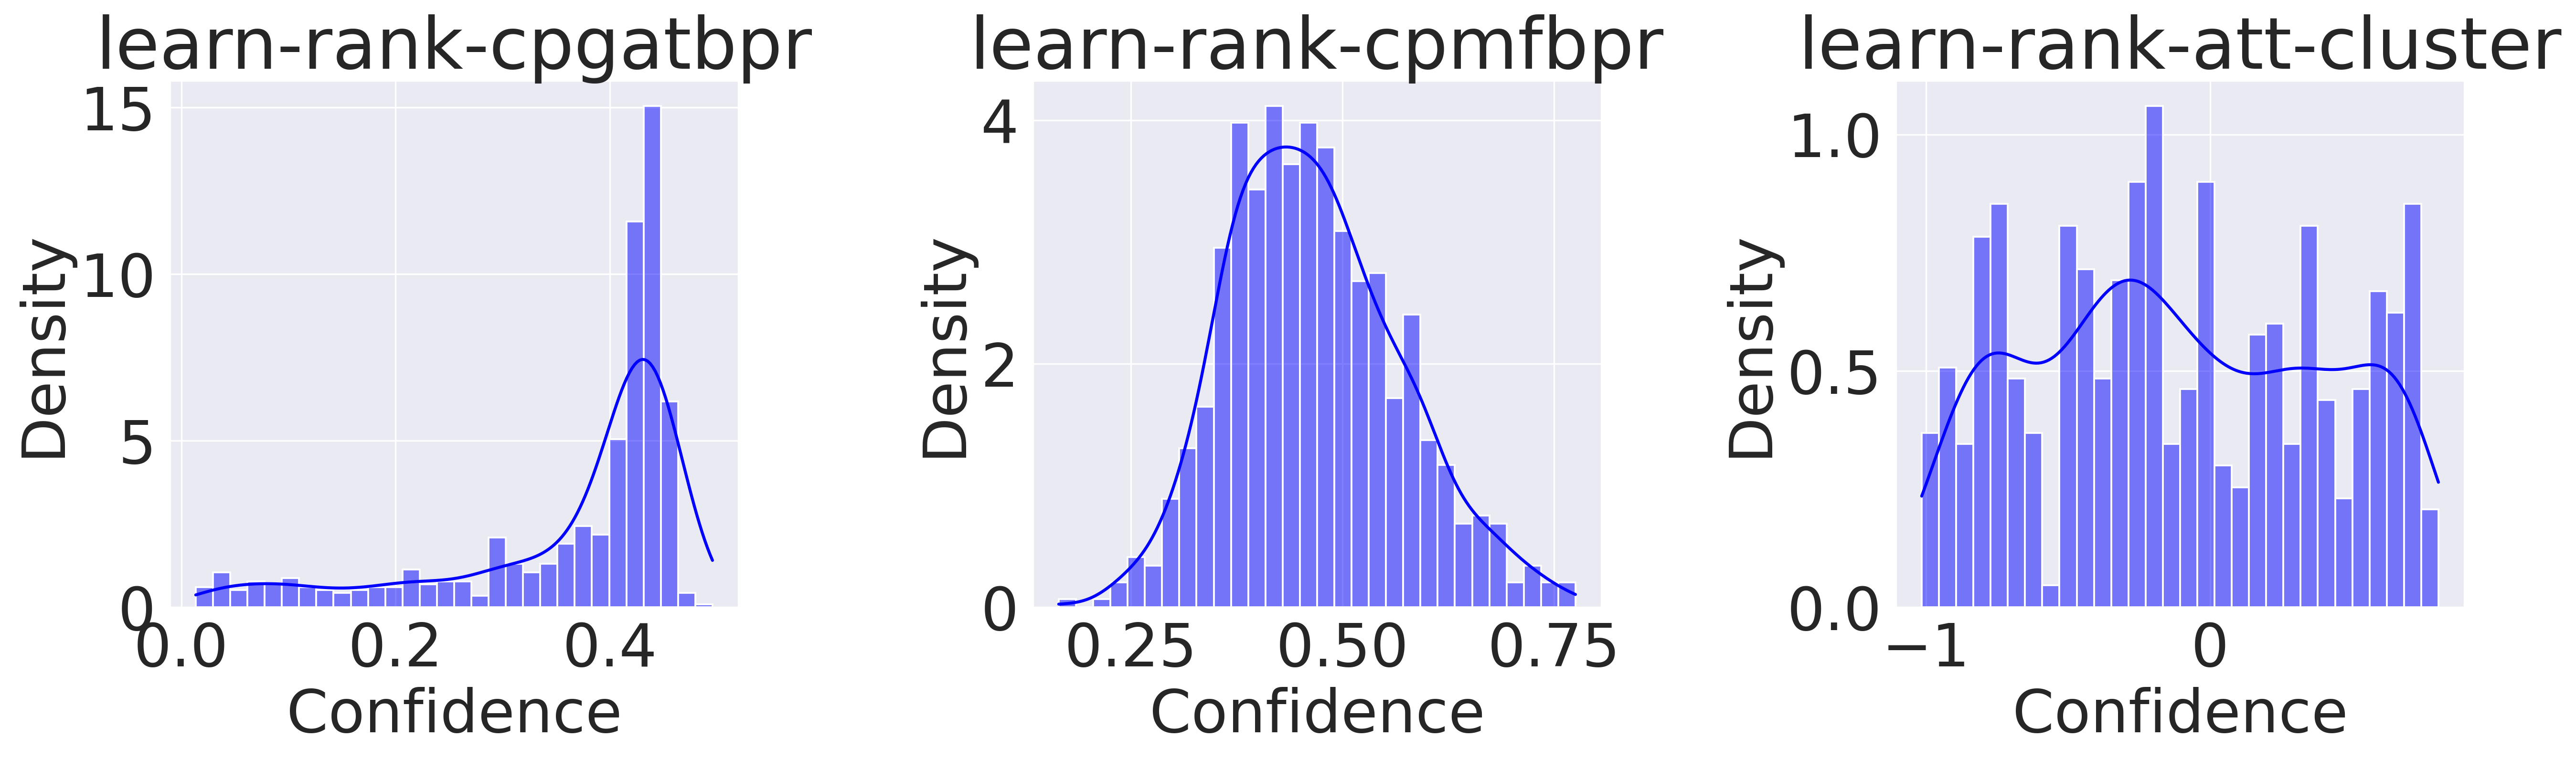

In [29]:
for dataset in test_results_dict.keys():

    print(f"{dataset}")
    plot_distributions_horizontally(test_results_dict[dataset], f"{group_name}-{dataset}-test", model_names)

amazon-beauty


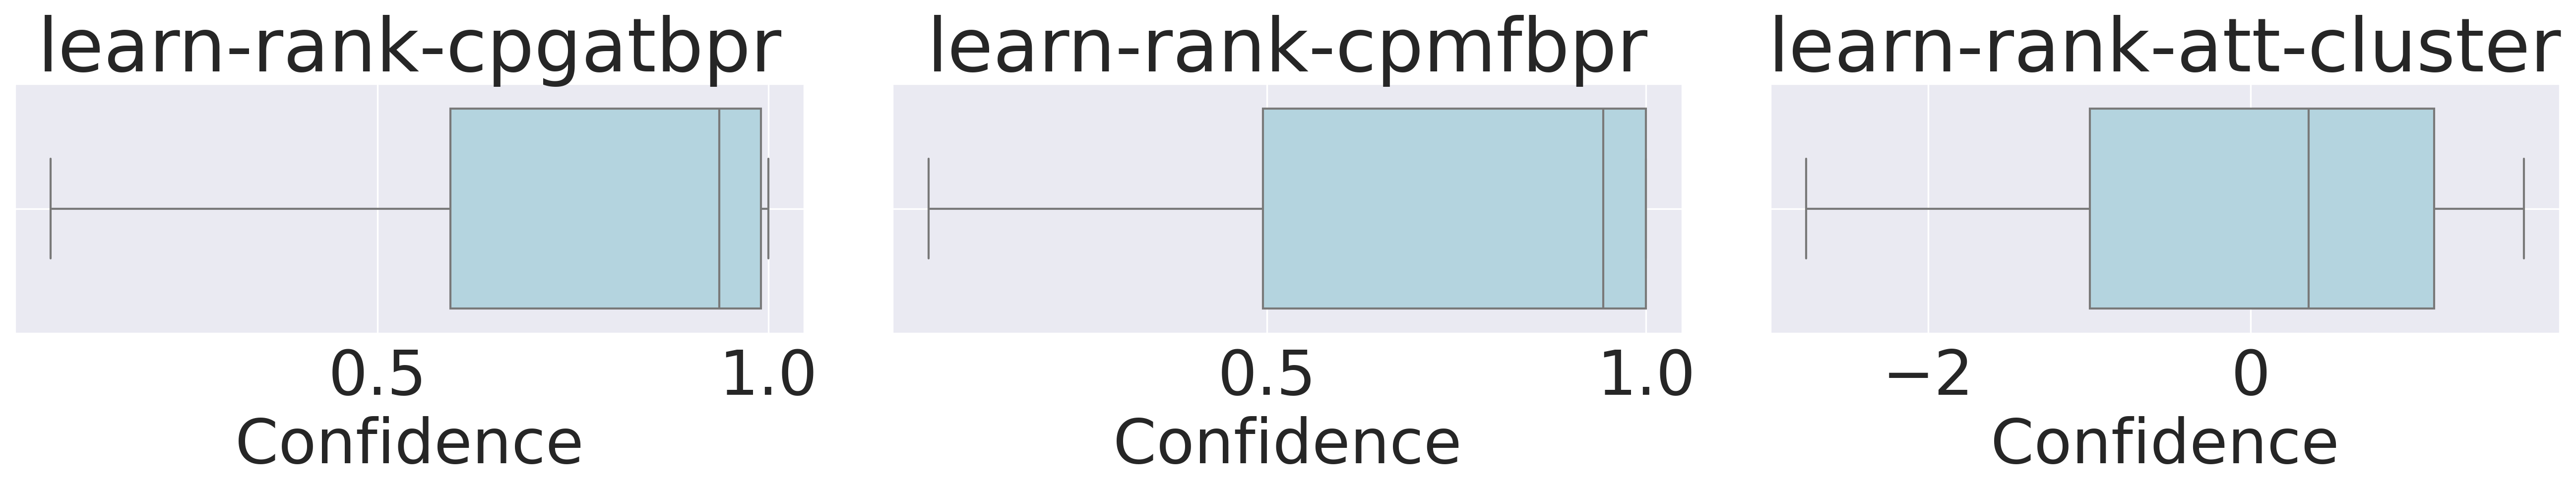

rotten-tomatoes


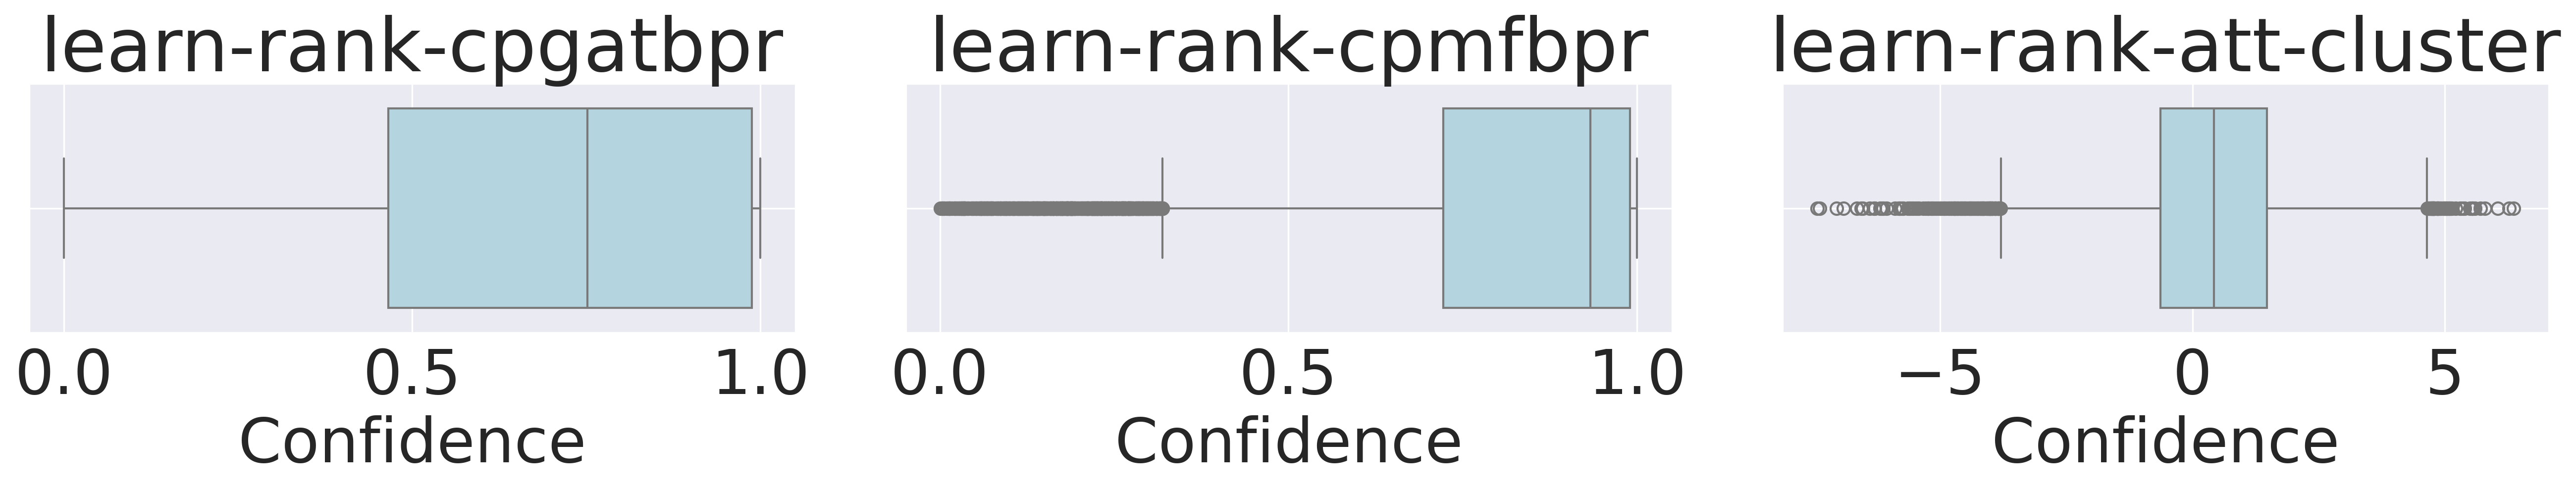

ml-1m


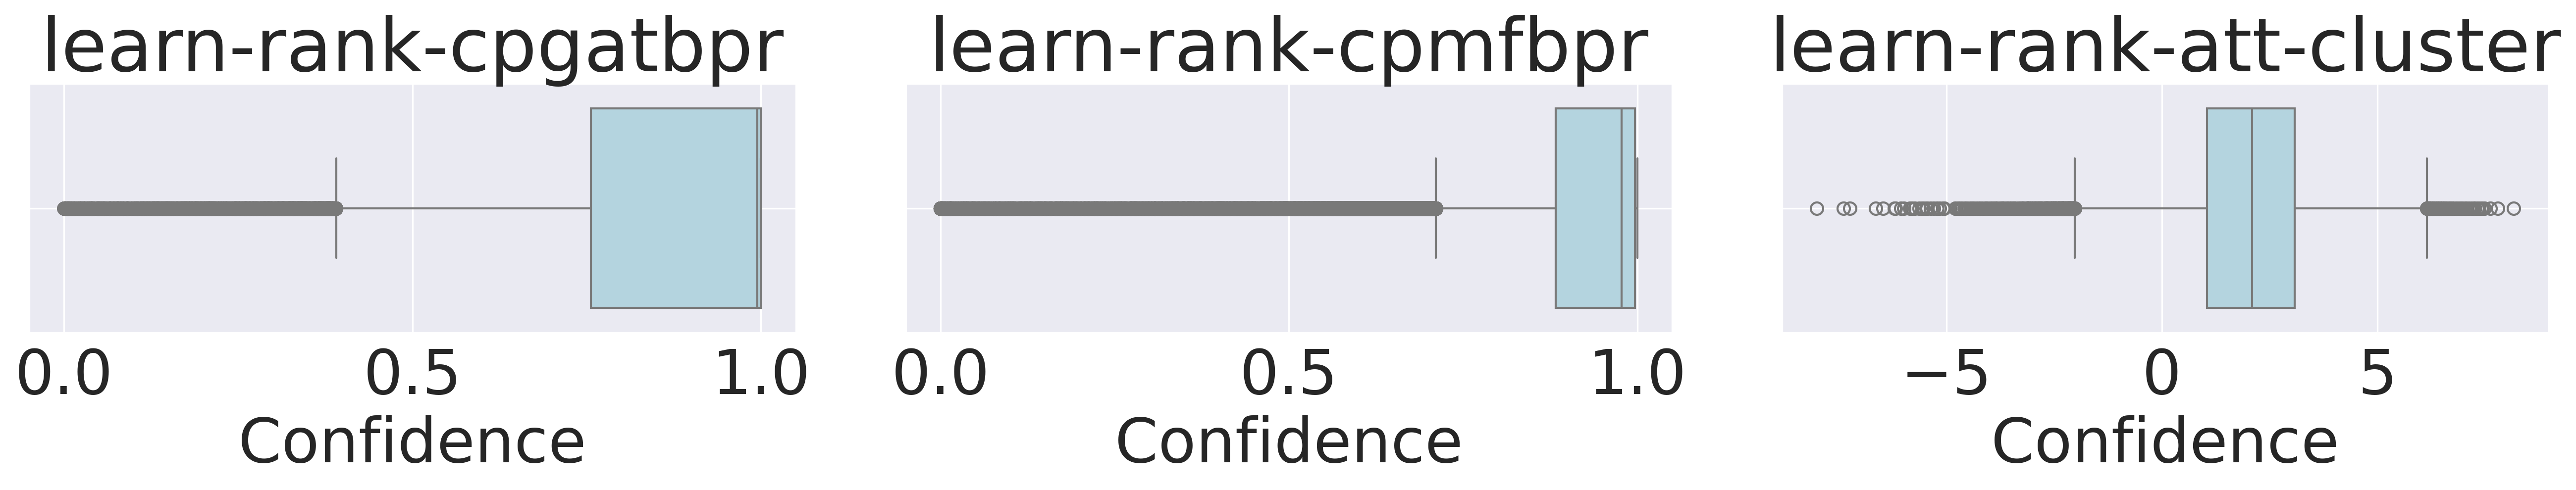

jester-joke


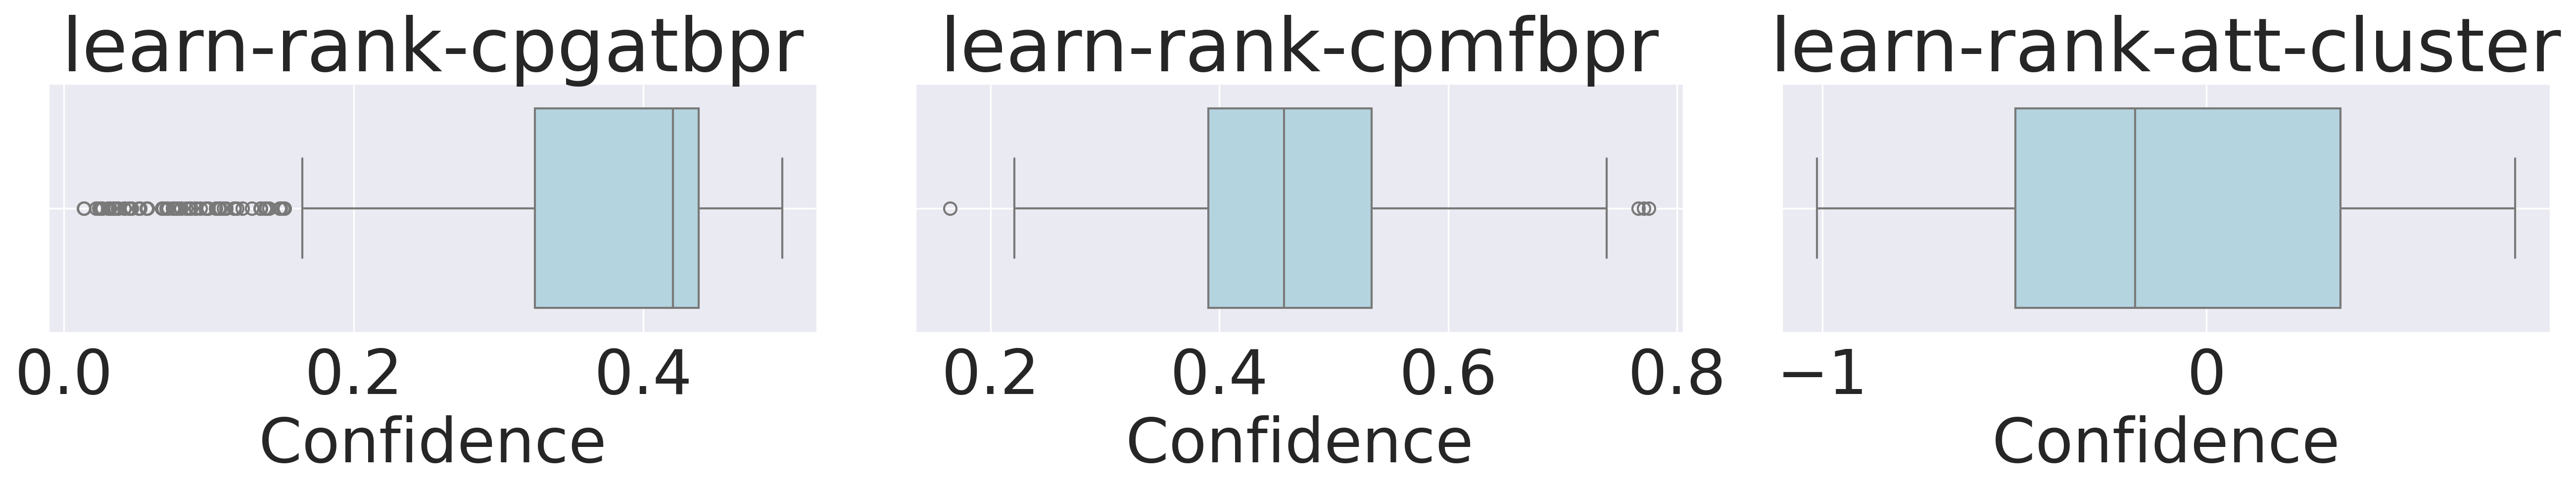

In [30]:
for dataset in test_results_dict.keys():

    print(f"{dataset}")
    plot_boxplots_horizontally(test_results_dict[dataset], f"box-plot-{group_name}-{dataset}-test", model_names)


In [31]:
corr_tables_folds = []
for k_instance in range(0, 5):
    test_results_dict = open_error_conf_dfs(f"../runs/{group_name}", k_instance=k_instance)

    models_corr = obtain_models_corr(test_results_dict, model_names)
    corr_table_df = []

    for database_name in models_corr.keys():
        df = pd.DataFrame(models_corr[database_name]).T
        df.columns = df.loc['name']
        df.drop("name", axis=0, inplace=True)
        df.index = [database_name]
        corr_table_df.append(df)

    corr_tables_folds.append(pd.concat(corr_table_df))


In [32]:
corr_df = pd.concat(corr_tables_folds)
group_corr_df = corr_df.reset_index().groupby(by='index')
mean_corr_df = group_corr_df.mean()
std_df_corr_df = group_corr_df.std()

In [33]:
def generate_coor_latex_table(mean_df: pd.DataFrame, std_df: pd.DataFrame, caption: str, label: str, columns: list):
    mean_df = mean_df.copy().astype(float).round(4)
    std_df = std_df.copy().astype(float).round(4)

    combined_df = pd.DataFrame(index=mean_df.index)

    for idx in mean_df.index:
        row = mean_df.loc[idx, columns]
        min_value = row.min()

        for col in columns:
            mean_val = mean_df.loc[idx, col]
            std_val = std_df.loc[idx, col]
            formatted = f"{mean_val:.4f} ± {std_val:.4f}"

            if mean_val == min_value:
                formatted = f"\\textbf{{{formatted}}}"

            combined_df.loc[idx, col] = formatted

    combined_df = combined_df.reset_index().rename(columns={"index": "database"})
    combined_df = combined_df[["database"] + columns]

    latex_code = combined_df.to_latex(
        label=label,
        caption=caption,
        index=False,
        escape=False,
        column_format="c" * len(combined_df.columns)
    )

    return latex_code

In [34]:
print(generate_coor_latex_table(mean_corr_df, std_df_corr_df, "Confidence correlation with error.", "tab:corr_error_distribution_based", model_names))

\begin{table}
\caption{Confidence correlation with error.}
\label{tab:corr_error_distribution_based}
\begin{tabular}{cccc}
\toprule
database & learn-rank-cpgatbpr & learn-rank-cpmfbpr & learn-rank-att-cluster \\
\midrule
amazon-beauty & -0.8159 ± 0.1340 & -0.7844 ± 0.0151 & \textbf{-0.9925 ± 0.0147} \\
jester-joke & -0.9937 ± 0.0072 & \textbf{-0.9996 ± 0.0001} & -0.9983 ± 0.0037 \\
ml-1m & 0.1237 ± 0.2670 & \textbf{-0.8936 ± 0.0338} & -0.0173 ± 0.5923 \\
rotten-tomatoes & -0.7216 ± 0.0485 & \textbf{-0.9361 ± 0.0048} & -0.5936 ± 0.1425 \\
\bottomrule
\end{tabular}
\end{table}



ml-1m - learn-rank-att-cluster


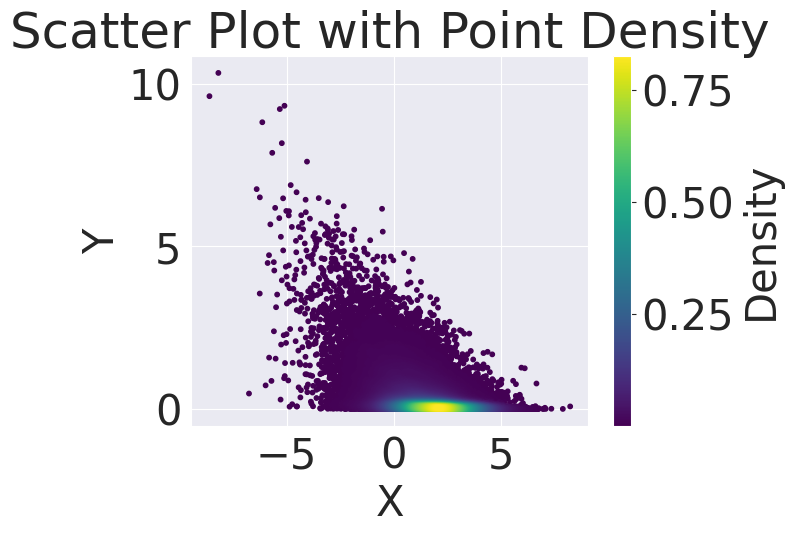

ml-1m - learn-rank-cpmfbpr


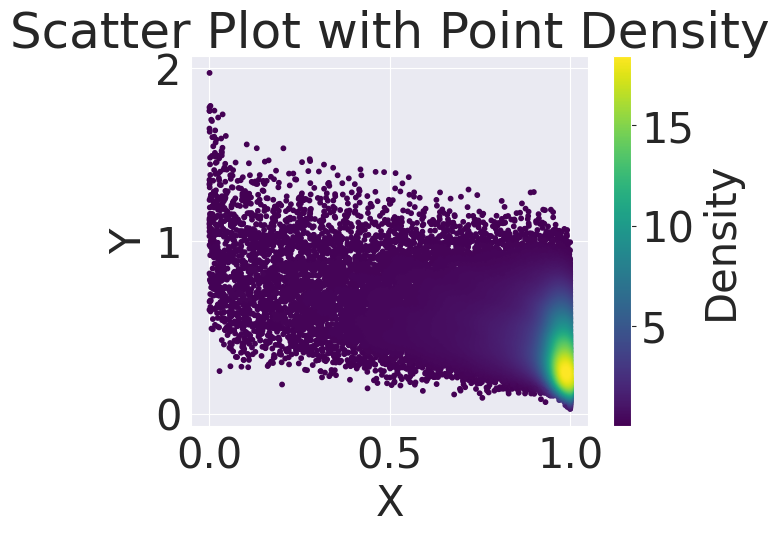

ml-1m - learn-rank-cpgatbpr


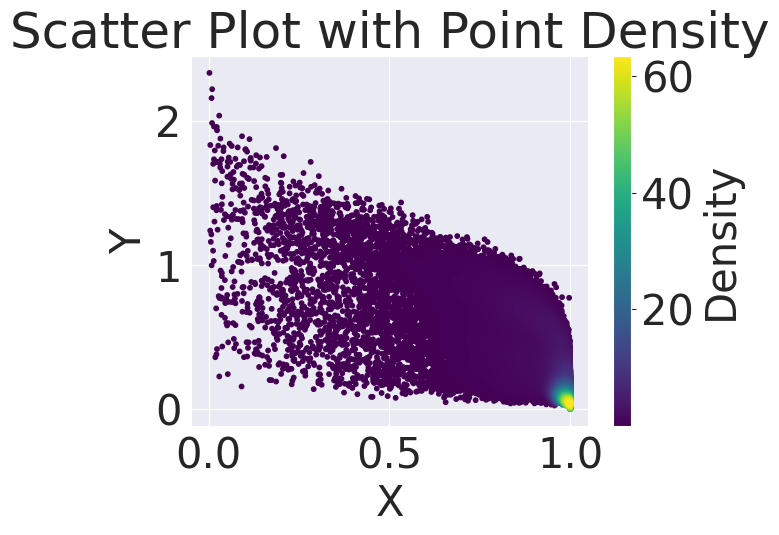

ml-1m - learn-rank-mf
Perfectly correlated.
ml-1m - learn-rank-dgatbpr
Perfectly correlated.
amazon-beauty - learn-rank-dgatbpr
Perfectly correlated.
amazon-beauty - learn-rank-att-cluster


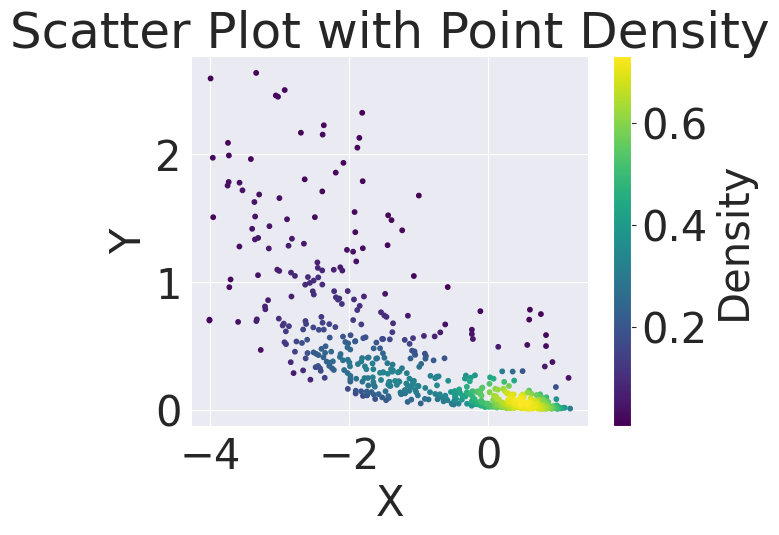

amazon-beauty - learn-rank-cpmfbpr


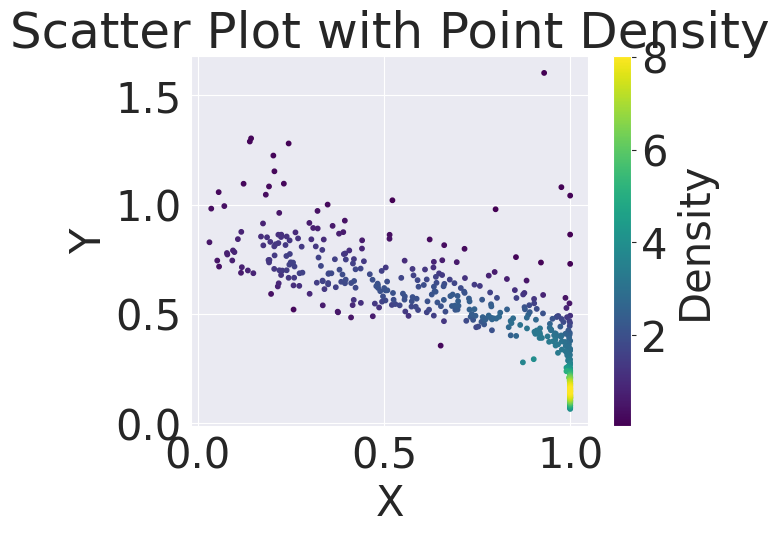

amazon-beauty - learn-rank-mf
Perfectly correlated.
amazon-beauty - learn-rank-cpgatbpr


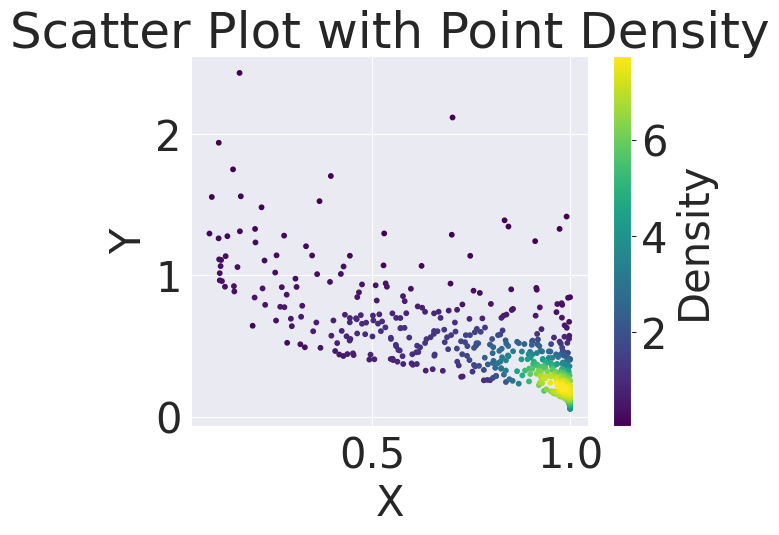

jester-joke - learn-rank-cpmfbpr


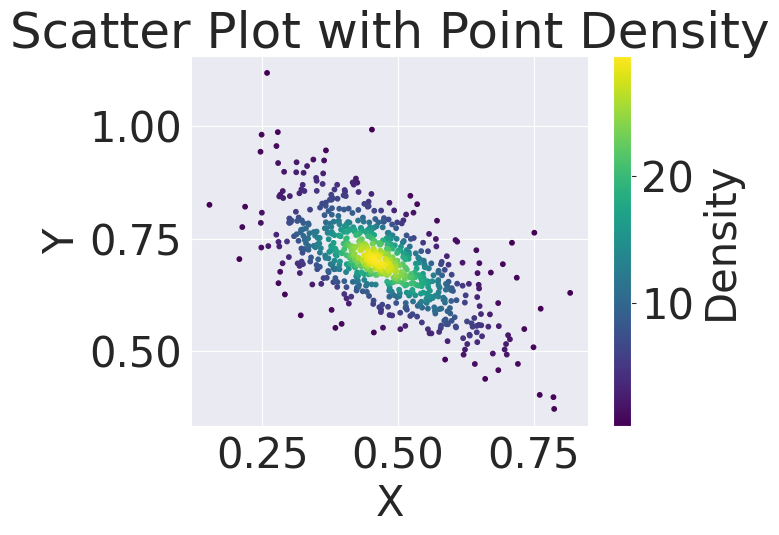

jester-joke - learn-rank-cpgatbpr


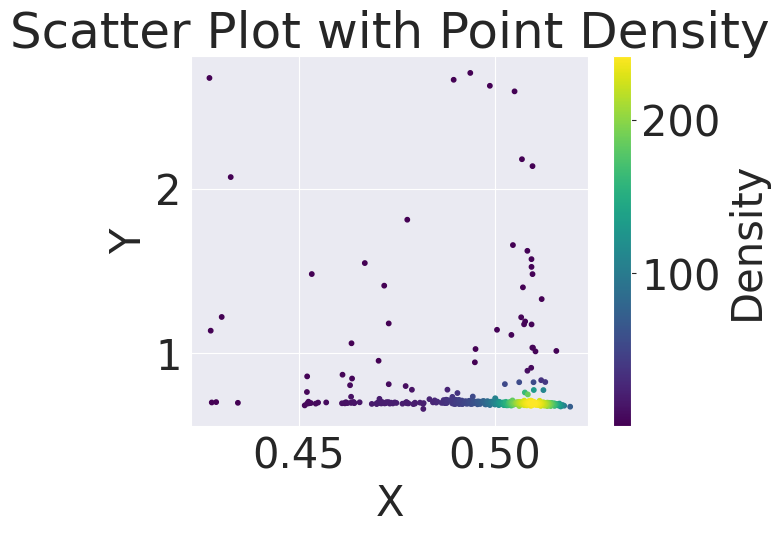

jester-joke - learn-rank-att-cluster


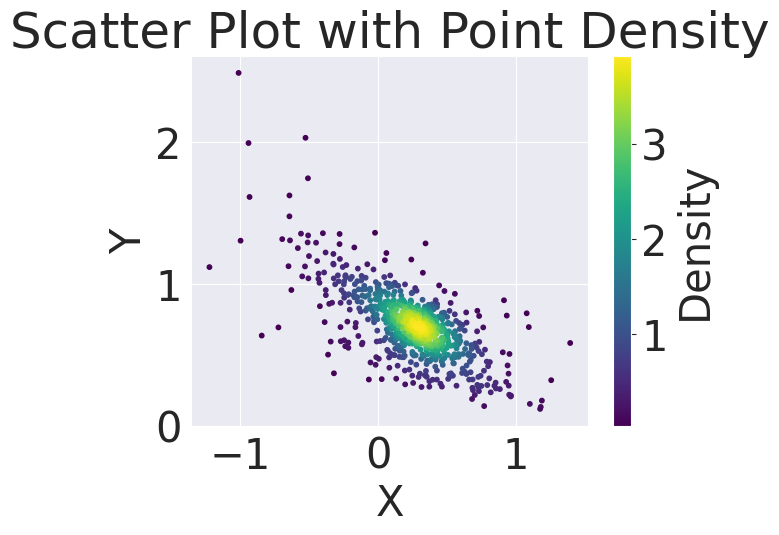

jester-joke - learn-rank-dgatbpr
Perfectly correlated.
jester-joke - learn-rank-mf
Perfectly correlated.
rotten-tomatoes - learn-rank-cpgatbpr


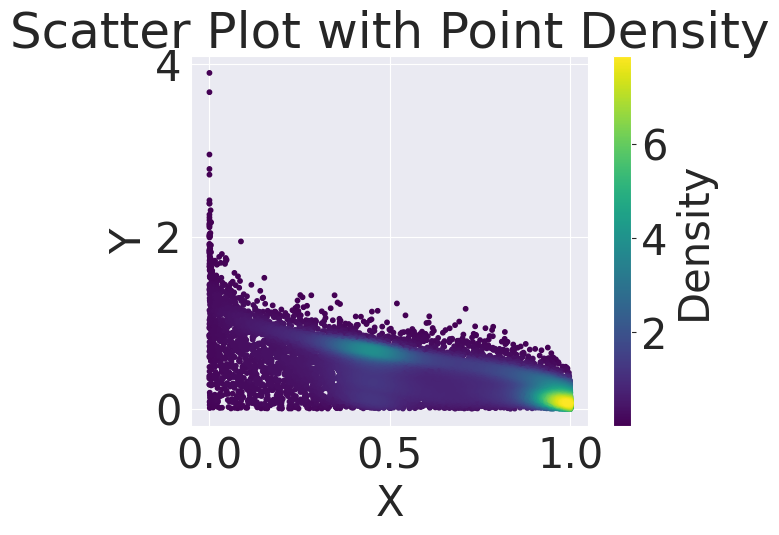

rotten-tomatoes - learn-rank-mf
Perfectly correlated.
rotten-tomatoes - learn-rank-cpmfbpr


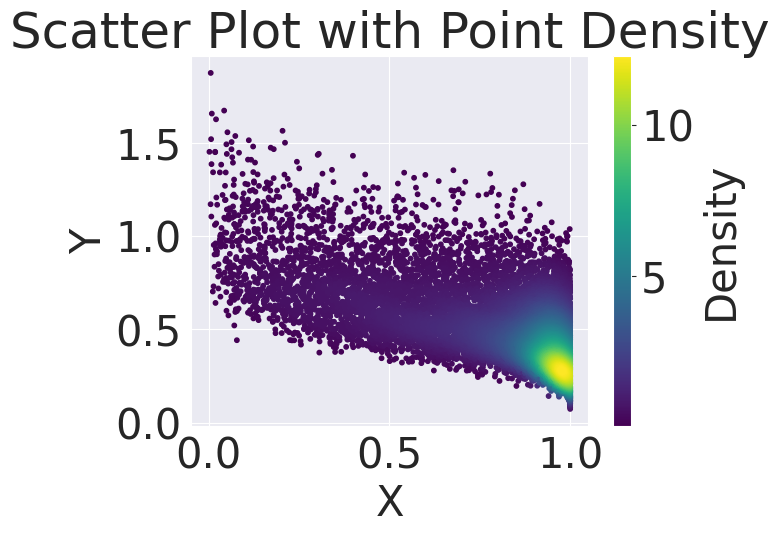

rotten-tomatoes - learn-rank-dgatbpr
Perfectly correlated.
rotten-tomatoes - learn-rank-att-cluster


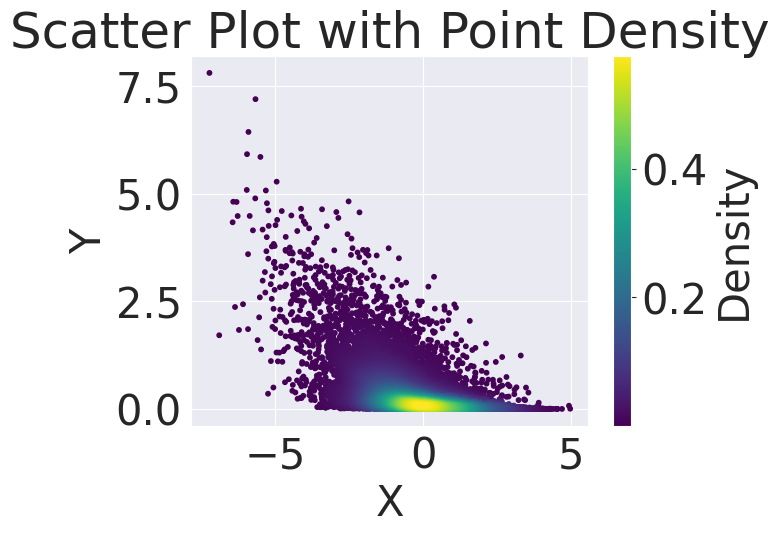

In [35]:
test_results_dict = open_error_conf_dfs(f"../runs/{group_name}", k_instance=k_instance)

for dataset_name in test_results_dict.keys():

    dataset_dict = test_results_dict[dataset_name]
    for model_name in dataset_dict.keys():

        model_dict = dataset_dict[model_name]
        model_results_df = model_dict['df']

        print(f"{dataset_name} - {model_name}")

        x = model_results_df['conf_pred'].values
        y = model_results_df['bpr_error'].values
        xy = np.vstack([x, y])

        try:
            z = gaussian_kde(xy)(xy)

            # Sort points by density so that high density plots on top
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx]

            # Create scatter plot with density colormap
            plt.scatter(x, y, c=z, s=10, cmap='viridis')
            plt.colorbar(label='Density')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title('Scatter Plot with Point Density')
            plt.show()
        except Exception as e:
            print("Perfectly correlated.")